# Base Code

# Full Code

100%|██████████| 50000/50000 [55:50<00:00, 14.92it/s]  


********Average reward per thousand episodes********

1000 :  12790.554605263153
2000 :  16040.193236842118
3000 :  17183.92626315789
4000 :  17743.740921052628
5000 :  17752.13855263158
6000 :  17897.004078947364
7000 :  17892.230157894723
8000 :  17870.30573684209
9000 :  17992.778236842078
10000 :  17861.81731578945
11000 :  18004.10307894735
12000 :  17942.564973684202
13000 :  17927.283894736836
14000 :  17950.34957894739
15000 :  17959.581131578932
16000 :  17884.868184210514
17000 :  17908.23999999999
18000 :  17893.948447368417
19000 :  17853.355578947372
20000 :  17931.312263157874
21000 :  17850.600236842143
22000 :  18043.59242105263
23000 :  18045.624394736835
24000 :  18089.355894736833
25000 :  18059.673921052643
26000 :  18111.57676315789
27000 :  18078.31813157896
28000 :  18218.573499999977
29000 :  18216.774289473695
30000 :  18221.43031578947
31000 :  18249.63321052631
32000 :  18393.57718421051
33000 :  18295.111263157887
34000 :  18353.02502631579
35000 :  18459.34

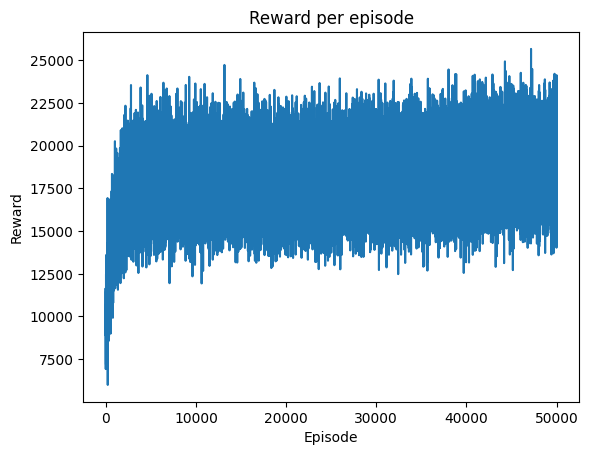

In [10]:
import numpy as np
import gym
from gym import spaces
from tqdm import tqdm
import matplotlib.pyplot as plt

def winprob(a, d):
    return 1/(1+np.exp(-3+3*a*(d+1)))

def stateTransition(s, win, lead, distance, d): 
    if win:
        return lead + 2 * (d+1) * distance
    return max(s - 1, 0)

def update_w(w):
    step_sizes = np.array([1, 3, 5])
    probabilities = np.array([0.5, 0.3, 0.2])
    step_size = np.random.choice(step_sizes, p=probabilities)

    if np.random.rand() < abs(w - 100) / 100.0:
        return max(w - step_size, 50) if w > 100 else min(w + step_size, 200)
    else:
        return min(w + step_size, 200) if w > 100 else max(w - step_size, 50)

def find_closest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

class ShippingEnv(gym.Env):
    def __init__(self):
        super(ShippingEnv, self).__init__()

        self.lead = 15
        self.distance = 20
        self.w_values = np.arange(50, 200)
        self.w = np.random.choice(self.w_values)
        self.T = 1000
        self.Arrivalprob = 0.3
        self.offer_values = np.linspace(0.5, 2, 20)
        self.destinations = np.array([0, 1])
        self.actions = [(a, d) for a in self.offer_values for d in self.destinations]

        self.observation_space = spaces.MultiDiscrete([self.lead + 2 * 2 * self.distance + 1, len(self.w_values)])
        self.action_space = spaces.Discrete(len(self.actions))

        self.state = (np.random.randint(0, self.observation_space.nvec[0]), np.random.choice(self.observation_space.nvec[1]))
        self.time = 0

    def step(self, action):
        assert self.action_space.contains(action)

        self.time += 1

        offer_received = np.random.rand() < self.Arrivalprob
        win = np.random.rand() < winprob(self.actions[action][0], self.actions[action][1])

        # Update w
        self.w = update_w(self.w)
        self.w = find_closest(self.w_values, self.w)
        w_index = np.where(self.w_values == self.w)[0][0]

        # If an offer is received, and the agent accepts it (action > 0), calculate reward and update state
        if offer_received and action > 0:
            self.state = (stateTransition(self.state[0], win, self.lead, self.distance, self.actions[action][1]), w_index)
            reward = win * self.actions[action][0] * (self.actions[action][1] + 1) * self.w
        else:
            self.state = (max(self.state[0] - 1, 0), w_index)
            reward = 0

        done = self.time == self.T

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = (np.random.randint(0, self.observation_space.nvec[0]), np.random.choice(self.observation_space.nvec[1]))
        self.time = 0
        return np.array(self.state)


# Define Q-Learning parameters
num_episodes = 50000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

# Initialize the environment
env = ShippingEnv()

# Initialize the Q-table
q_table = np.zeros((env.observation_space.nvec[0], env.observation_space.nvec[1], env.action_space.n))

# List to hold all rewards
rewards_all_episodes = []

# Q-Learning algorithm
for episode in tqdm(range(num_episodes)):
    state = env.reset()

    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode): 

        # Exploration-exploitation trade-off
        exploration_rate_threshold = np.random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state[0], state[1], :]) 
        else:
            action = np.random.choice(env.action_space.n) 

        new_state, reward, done, info = env.step(action)

        # Update Q-table for Q(s,a)
        q_table[state[0], state[1], action] = q_table[state[0], state[1], action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_state[0], new_state[1], :]))

        state = new_state
        rewards_current_episode += reward 

        if done == True: 
            break

    # Exploration rate decay
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
 
    rewards_all_episodes.append(rewards_current_episode)

# Calculate and print the average reward per thousand episodes
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes),num_episodes/1000)
count = 1000
print("********Average reward per thousand episodes********\n")
for r in rewards_per_thousand_episodes:
    print(count, ": ", str(sum(r/1000)))
    count += 1000

# Visualize the reward
plt.plot(rewards_all_episodes)
plt.title('Reward per episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

# Q1,2

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm import tqdm

# Functions and environment definition
def winprob(a):
    return 1 / (1 + np.exp(-3 + 3 * a))

def stateTransition(s, win, lead, distance): 
    if win:
        return lead + 2 * distance
    return max(s - 1, 0)

class ShippingEnv(gym.Env):
    def __init__(self):
        super(ShippingEnv, self).__init__()
        self.lead = 15
        self.distance = 20
        self.w = 100
        self.T = 1000
        self.Arrivalprob = 0.3
        self.actions = np.linspace(0.85, 0.95, 16)
        self.observation_space = gym.spaces.Discrete(self.lead + 2 * self.distance + 1)
        self.action_space = gym.spaces.Discrete(len(self.actions))
        self.state = (np.random.randint(0, self.observation_space.n), self.w)
        self.time = 0

    def wScenaria(self, w):
        upprob = 1 / (1 + np.exp(-3 + 3 * w / 100))
        downprob = 1 - upprob
        scenaria = [(max(min(w + 15, 200), 50), upprob / 2),
                    (max(min(w + 5, 200), 50), upprob / 2),
                    (max(min(w - 5, 200), 50), downprob / 2),
                    (max(min(w - 15, 200), 50), downprob / 2)]
        return scenaria

    def step(self, action):
        s, w = self.state
        self.time += 1
        offer_received = np.random.rand() < self.Arrivalprob
        win = np.random.rand() < winprob(self.actions[action])
        if offer_received and action > 0:
            s = stateTransition(s, win, self.lead, self.distance)
            reward = win * self.actions[action] * w
        else:
            s = max(s - 1, 0)
            reward = 0
        new_w = np.random.choice([scen[0] for scen in self.wScenaria(w)], p=[scen[1] for scen in self.wScenaria(w)])
        self.state = (s, new_w)
        done = self.time == self.T
        return self.state, reward, done, {}

    def reset(self):
        self.state = (np.random.randint(0, self.observation_space.n), self.w)
        self.time = 0
        return self.state

# Q-Learning parameters
num_episodes = 50000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_rate = 0.99
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

# Initialize the environment
env = ShippingEnv()
q_table = np.zeros((env.observation_space.n, env.action_space.n))
rewards_all_episodes = []

for episode in tqdm(range(num_episodes)):
    state = env.reset()
    s, w = state
    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode): 
        exploration_rate_threshold = np.random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[s,:]) 
        else:
            action = np.random.choice(env.action_space.n) 
        new_state, reward, done, _ = env.step(action)
        new_s, new_w = new_state
        q_table[s, action] = q_table[s, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_s, :]))
        s, w = new_s, new_w
        rewards_current_episode += reward 
        if done: 
            break
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    rewards_all_episodes.append(rewards_current_episode)


100%|██████████| 50000/50000 [49:04<00:00, 16.98it/s]  


ValueError: Must pass 2-d input. shape=(96, 51, 16)

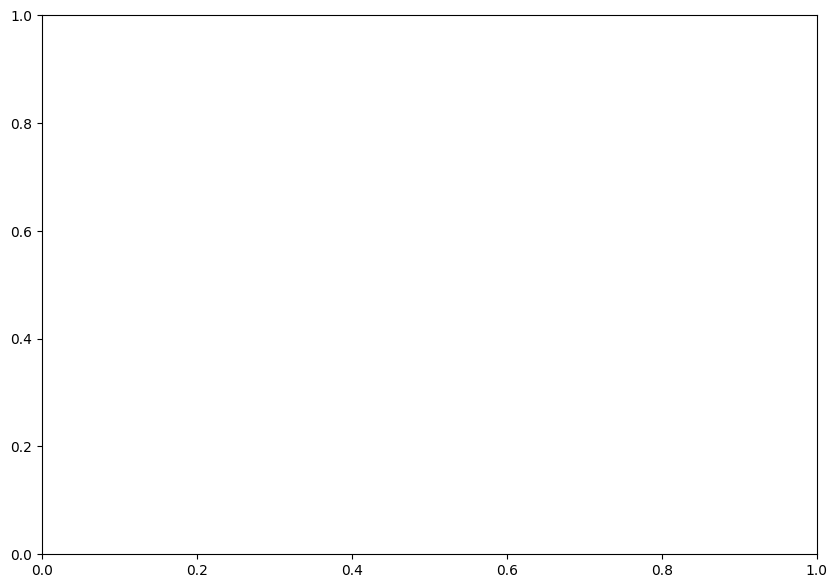

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you've trained a Q-table named 'q_table' for the original problem

# Extract optimal actions for each combination of state and w
optimal_actions = np.argmax(q_table, axis=2)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(optimal_actions, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'Optimal Action Index'})
ax.set_title('Optimal Action')
ax.set_xlabel('w values')
ax.set_ylabel('State')
ax.set_xticks(np.arange(len(w_values)))
ax.set_xticklabels(w_values, rotation=90)

plt.tight_layout()
plt.show()


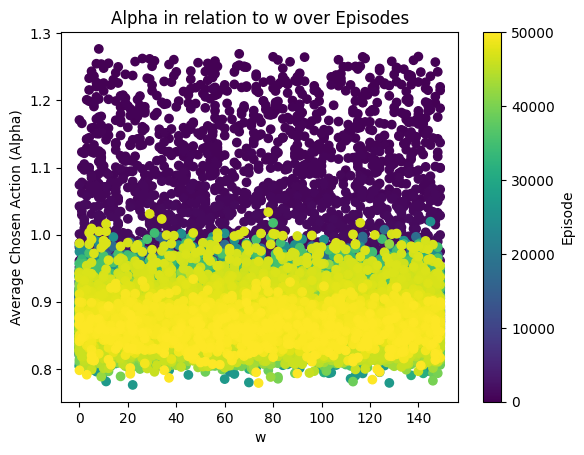

# Q3

In [22]:
import gym
import numpy as np
from tqdm import tqdm

PORT_A = 0
PORT_B = 1
DISTANCE_A = 20
DISTANCE_B = 40

def winprob(a):
    return 1 / (1 + np.exp(-3 + 3 * a))

def stateTransition(s, win, lead, p):
    if win:
        if p == PORT_A:
            return lead + 2 * DISTANCE_A
        else:
            return lead + 2 * DISTANCE_B
    else:
        return max(s-1, 0)

def wScenaria(w, p):
    if p == PORT_A:
        upprob = 1 / (1 + np.exp(-3 + 3 * w / 100))
        downprob = 1 - upprob
        return [
            (max(min(w + 15, 200), 50), upprob / 3),
            (max(min(w + 5, 200), 50), upprob * 2 / 3),
            (max(min(w - 5, 200), 50), downprob / 3),
            (max(min(w - 15, 200), 50), downprob * 2 / 3)
        ]
    else:  # PORT_B
        upprob = 1 / (1 + np.exp(-3 + 3 * w / 200))
        downprob = 1 - upprob
        return [
            (max(min(w + 30, 400), 100), upprob / 3),
            (max(min(w + 10, 400), 100), upprob * 2 / 3),
            (max(min(w - 10, 400), 100), downprob / 3),
            (max(min(w - 30, 400), 100), downprob * 2 / 3)
        ]


class ShippingEnv(gym.Env):
    def __init__(self):
        super(ShippingEnv, self).__init__()
        self.lead = 15
        self.T = 1000
        self.Arrivalprob = 0.3
        self.actions = np.array([(a, p) for a in np.linspace(0.85, 0.95, 16) for p in [PORT_A, PORT_B]])
        self.observation_space = gym.spaces.Discrete(self.lead + 2 * DISTANCE_B + 1)
        self.action_space = gym.spaces.Discrete(len(self.actions))
        self.state = (np.random.randint(0, self.lead + 2 * DISTANCE_B + 1), np.random.randint(50, 205, 5))
        self.time = 0
        self.w = 100

    def wScenaria(self, w, p):
        return wScenaria(w, p)

    def step(self, action):
        s, w = self.state
        a, p = self.actions[action]
        self.time += 1
        offer_received = np.random.rand() < self.Arrivalprob
        win = np.random.rand() < winprob(a)
        if offer_received and action > 0:
            s = stateTransition(s, win, self.lead, p)
            reward = win * a * w
        else:
            s = max(s - 1, 0)
            reward = 0
        new_w = np.random.choice([scen[0] for scen in self.wScenaria(w, p)], p=[scen[1] for scen in self.wScenaria(w, p)])
        self.state = (s, new_w)
        done = self.time == self.T
        return self.state, reward, done, {}

    def reset(self):
        self.state = (np.random.randint(0, self.lead + 2 * DISTANCE_B + 1), np.random.choice(list(np.arange(50, 205, 5))))
        self.time = 0
        return self.state

# Q-Learning parameters
num_episodes = 50000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_rate = 0.99
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

# Initialize the environment
env = ShippingEnv()
q_table = np.zeros((env.observation_space.n, env.action_space.n))
rewards_all_episodes = []

for episode in tqdm(range(num_episodes)):
    state = env.reset()
    s, w = state
    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode):
        exploration_rate_threshold = np.random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[s, :]) 
        else:
            action = np.random.choice(env.action_space.n) 

        new_state, reward, done, _ = env.step(action)
        new_s, new_w = new_state
        q_table[s, action] = q_table[s, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_s, :]))
        s, w = new_s, new_w
        rewards_current_episode += reward 
        if done: 
            break

    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
    rewards_all_episodes.append(rewards_current_episode)



""" # Plotting the heatmaps

import seaborn as sns
import matplotlib.pyplot as plt

# Extract optimal actions for each combination of state and w for both ports
optimal_actions_A = np.argmax(q_table[:, :, PORT_A, :], axis=2)
optimal_actions_B = np.argmax(q_table[:, :, PORT_B, :], axis=2)

# Plotting the heatmaps
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

sns.heatmap(optimal_actions_A, ax=ax[0], cmap="YlGnBu", cbar_kws={'label': 'Optimal Action Index'})
ax[0].set_title('Optimal Action for PORT A')
ax[0].set_xlabel('w values')
ax[0].set_ylabel('State')
ax[0].set_xticks(np.arange(len(env.w_values)))
ax[0].set_xticklabels(env.w_values, rotation=90)

sns.heatmap(optimal_actions_B, ax=ax[1], cmap="YlGnBu", cbar_kws={'label': 'Optimal Action Index'})
ax[1].set_title('Optimal Action for PORT B')
ax[1].set_xlabel('w values')
ax[1].set_ylabel('State')
ax[1].set_xticks(np.arange(len(env.w_values)))
ax[1].set_xticklabels(env.w_values, rotation=90)

plt.tight_layout()
plt.show()
 """


  0%|          | 0/50000 [00:00<?, ?it/s]

 23%|██▎       | 11419/50000 [14:44<49:47, 12.92it/s]  


KeyboardInterrupt: 

# Q4

In [24]:
import gym
import numpy as np
from tqdm import tqdm

PORT_A = 0
PORT_B = 1
DISTANCE_A = 20
DISTANCE_B = 40

def winprob(a):
    return 1 / (1 + np.exp(-3 + 3 * a))

def stateTransition(s, win, lead, p):
    if win:
        if p == PORT_A:
            return lead + 2 * DISTANCE_A
        else:
            return lead + 2 * DISTANCE_B
    else:
        return max(s - 1, 0)

def wScenaria(w, p):
    if p == PORT_A:
        upprob = 1 / (1 + np.exp(-3 + 3 * w / 100))
        downprob = 1 - upprob
        return [
            (max(min(w + 15, 200), 50), upprob / 3),
            (max(min(w + 5, 200), 50), upprob * 2 / 3),
            (max(min(w - 5, 200), 50), downprob / 3),
            (max(min(w - 15, 200), 50), downprob * 2 / 3)
        ]
    else:  # PORT_B
        upprob = 1 / (1 + np.exp(-3 + 3 * w / 200))
        downprob = 1 - upprob
        return [
            (max(min(w + 30, 400), 100), upprob / 3),
            (max(min(w + 10, 400), 100), upprob * 2 / 3),
            (max(min(w - 10, 400), 100), downprob / 3),
            (max(min(w - 30, 400), 100), downprob * 2 / 3)
        ]

class ShippingEnv(gym.Env):
    def __init__(self):
        super(ShippingEnv, self).__init__()
        self.lead = 15
        self.T = 1000
        self.Arrivalprob = {PORT_A: 0.3, PORT_B: 0.15}
        self.actions = np.array([(a, p) for a in np.linspace(0.85, 0.95, 16) for p in [PORT_A, PORT_B]])
        self.observation_space = gym.spaces.Discrete(self.lead + 2 * DISTANCE_B + 1)
        self.action_space = gym.spaces.Discrete(len(self.actions))
        self.state = (np.random.randint(0, self.lead + 2 * DISTANCE_B + 1), np.random.randint(50, 205, 5))
        self.time = 0
        self.w = 100

    def step(self, action):
        s, w = self.state
        a, p = self.actions[action]
        self.time += 1
        offer_received = np.random.rand() < self.Arrivalprob[p]
        win = np.random.rand() < winprob(a)
        if offer_received and action > 0:
            s = stateTransition(s, win, self.lead, p)
            reward = win * a * w
        else:
            s = max(s - 1, 0)
            reward = 0
        new_w = np.random.choice([scen[0] for scen in wScenaria(w, p)], p=[scen[1] for scen in wScenaria(w, p)]) # Standalone function call
        self.state = (s, new_w)
        done = self.time == self.T
        return self.state, reward, done, {}

    def reset(self):
        self.state = (np.random.randint(0, self.lead + 2 * DISTANCE_B + 1), np.random.choice(list(np.arange(50, 205, 5))))
        self.time = 0
        return self.state

# Q-Learning parameters
num_episodes = 50000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_rate = 0.99
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

# Initialize the environment
env = ShippingEnv()
q_table = np.zeros((env.observation_space.n, env.action_space.n))
rewards_all_episodes = []

for episode in tqdm(range(num_episodes)):
    state = env.reset()
    s, w = state
    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode):
        exploration_rate_threshold = np.random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[s, :])
        else:
            action = np.random.choice(env.action_space.n)

        new_state, reward, done, _ = env.step(action)
        new_s, new_w = new_state
        q_table[s, action] = q_table[s, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_s, :]))
        s, w = new_s, new_w
        rewards_current_episode += reward
        if done:
            break

    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
    rewards_all_episodes.append(rewards_current_episode)


  0%|          | 0/50000 [00:00<?, ?it/s]

  1%|▏         | 640/50000 [01:57<2:31:05,  5.45it/s]


KeyboardInterrupt: 

# Q5

In [25]:
import gym
import numpy as np
from tqdm import tqdm

PORT_A = 0
PORT_B = 1
DISTANCE_A = 20
DISTANCE_B = 40
LEAD_A = 5
LEAD_B = 15
lead_times = {PORT_A: LEAD_A, PORT_B: LEAD_B}
Arrivalprob = {PORT_A: 0.3, PORT_B: 0.15}

def winprob(a):
    return 1 / (1 + np.exp(-3 + 3 * a))

def stateTransition(s, win, p):
    if win:
        return lead_times[p] + 2 * (DISTANCE_A if p == PORT_A else DISTANCE_B)
    else:
        return max(s - 1, 0)

def wScenaria(w, p):
    if p == PORT_A:
        upprob = 1 / (1 + np.exp(-3 + 3 * w / 100))
        downprob = 1 - upprob
        return [
            (max(min(w + 15, 200), 50), upprob / 3),
            (max(min(w + 5, 200), 50), upprob * 2 / 3),
            (max(min(w - 5, 200), 50), downprob / 3),
            (max(min(w - 15, 200), 50), downprob * 2 / 3)
        ]
    else:  # PORT_B
        upprob = 1 / (1 + np.exp(-3 + 3 * w / 200))
        downprob = 1 - upprob
        return [
            (max(min(w + 30, 400), 100), upprob / 3),
            (max(min(w + 10, 400), 100), upprob * 2 / 3),
            (max(min(w - 10, 400), 100), downprob / 3),
            (max(min(w - 30, 400), 100), downprob * 2 / 3)
        ]
    
class ShippingEnv(gym.Env):
    def __init__(self):
        super(ShippingEnv, self).__init__()
        self.max_lead = max(lead_times.values())
        self.T = 1000
        self.actions = np.array([(a, p) for a in np.linspace(0.85, 0.95, 16) for p in [PORT_A, PORT_B]])
        self.observation_space = gym.spaces.Discrete(self.max_lead + 2 * DISTANCE_B + 1)
        self.action_space = gym.spaces.Discrete(len(self.actions))
        self.state = (np.random.randint(0, self.max_lead + 2 * DISTANCE_B + 1), np.random.randint(50, 205, 5))
        self.time = 0

    def step(self, action):
        s, w = self.state
        a, p = self.actions[action]
        self.time += 1
        offer_received = np.random.rand() < Arrivalprob[p]
        win = np.random.rand() < winprob(a)
        s = stateTransition(s, win, p)
        reward = (win * a * w) if offer_received and action > 0 else 0
        new_w = np.random.choice([scen[0] for scen in wScenaria(w, p)], p=[scen[1] for scen in wScenaria(w, p)])
        self.state = (s, new_w)
        done = self.time == self.T
        return self.state, reward, done, {}

    def reset(self):
        self.state = (np.random.randint(0, self.max_lead + 2 * DISTANCE_B + 1), np.random.choice(list(np.arange(50, 205, 5))))
        self.time = 0
        return self.state
    

# Q-Learning parameters
num_episodes = 50000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_rate = 0.99
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

# Initialize the environment
env = ShippingEnv()
q_table = np.zeros((env.observation_space.n, env.action_space.n))
rewards_all_episodes = []

for episode in tqdm(range(num_episodes)):
    state = env.reset()
    s, w = state
    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode):
        exploration_rate_threshold = np.random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[s, :])
        else:
            action = np.random.choice(env.action_space.n)

        new_state, reward, done, _ = env.step(action)
        new_s, new_w = new_state
        q_table[s, action] = q_table[s, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_s, :]))
        s, w = new_s, new_w
        rewards_current_episode += reward
        if done:
            break

    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
    rewards_all_episodes.append(rewards_current_episode)

  0%|          | 48/50000 [00:04<1:20:59, 10.28it/s]


KeyboardInterrupt: 